In [9]:
import fun.em.em as em
from util.math.linear import (
    column_vector, column_indicator, inner_product
)
from util.plot import *

import numpy as np
from numpy.linalg import inv
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import patsy

# Import Sample Data from ISLP

In [10]:
from ISLP import load_data

In [11]:
# We use the Boston Housing Data from the module ISLP.
# medv is median house value, what we want to predict.
# 
# We only select subset of predictors.
# rm: average number of rooms
# age: proportion of owner-occupied units built prior to 1940
# lstat: percentage of households with low socioeconomic status

boston = load_data("Boston")
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [12]:
# We use patsy for dmatrices, which behaves similarly as numpy
X, A = patsy.dmatrices("medv~rm+age+lstat-1", boston) #we use X, A to be consistent with the notes.
print(X.shape)
print(A.shape)
beta_lr = inv(A.T@A)@A.T@X
print("Trained Beta", np.round(beta_lr.T, 2))

(506, 1)
(506, 3)
Trained Beta [[ 4.85  0.01 -0.68]]


# Censored Regression
## Fake Data Generation
Following the book, $X = A\beta + U$. But only $Y_i = \min(X_i, c_i)$ is observed.

In [13]:
np.random.seed(2)
n = X.shape[0]
beta = column_vector([3, 2, -0.9])
sigma = 10
U = column_vector(np.random.normal(0, 1, n))

X_true = A@beta + sigma * U

In [14]:
np.random.seed(2)
c = column_vector(np.random.binomial(1, 0.5, n)) * 0.7 # 40% cencsored to be 70%
c[c == 0] = X_true[c == 0] * 10 # censored
C = X_true * c 
Y = np.minimum(X_true, C  ) # IMPORTANT!! Assumed that all X_true are positive

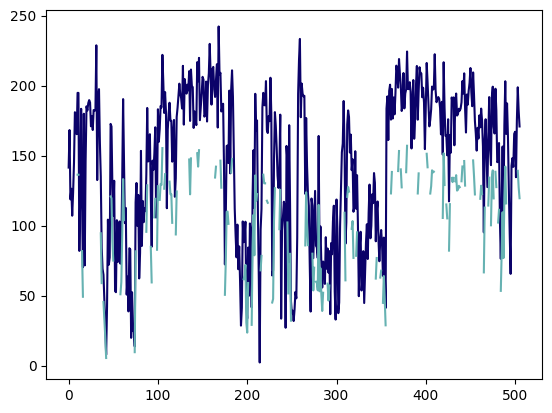

In [15]:
plt.plot(X_true)
plt.plot(np.where(Y< X_true, Y, -np.inf))

## Train with Linear Regression Method

In [16]:
beta_lr = inv(A.T@A)@A.T@Y
print("Trained", np.round(beta_lr.T, 2))
print("True", beta.T)
print("It differs quite a lot.")

Trained [[ 2.69  1.7  -0.86]]
True [[ 3.   2.  -0.9]]
It differs quite a lot.


## Train with Censored Regression Method

In [17]:
def get_H(v):
    a =  norm.pdf(v) / (1 - norm.cdf(v))
    return a

def get_Hn(c, A, beta_n, sigma_n, In):
    return get_H((c - A@beta_n)/sigma_n * In)

def get_In(C, Y):
    return column_indicator(C == Y)

def get_bar_S(C, A, beta_n, sigma_n, In, Hn):
    out = (A@beta_n + (sigma_n**2) * np.ones(C.shape) + sigma_n* (C + A@beta_n) * Hn) * In
    return np.where(np.isnan(out), 0, out)

def get_S(Y, In):
    return Y * (1 - In)

def get_expectation_X(A, beta_n, sigma_n, In, Hn, S):
    temp = (A@beta_n + sigma_n * Hn) * In
    temp = np.where(np.isnan(temp), 0, temp)
    return temp + S

def get_expectation_X2(bar_S, S):
    return (inner_product(bar_S, bar_S) + inner_product(S, S))

In [18]:
def update_em(data, theta):
    # Reading data
    y, c, A = data
    m = A.shape[1]

    # Load paramter
    beta_n, sigma2_n = column_vector(theta[:m]), theta[m]
    sigma_n = np.sqrt(sigma2_n)

    # Compute
    In = get_In(c, y)
    
    Hn =  get_Hn(c, A, beta_n, sigma_n, In)
    Hn = np.where(np.isinf(Hn), 3, Hn)

    # Compute S
    bar_S = get_bar_S(C, A, beta_n, sigma, In, Hn)
    S = get_S(Y, In)

    # Compute Expectation
    E_X = get_expectation_X(A, beta_n, sigma, In, Hn, S)
    E_X2 = get_expectation_X2(bar_S, S)
    

    beta_np1 = inv(A.T@A)@A.T@E_X

    # Compute
    r = Y.shape[0]
    sigma2_np1 =  1/r * (
            inner_product(A@beta_np1, A@beta_np1) 
            - 2 * inner_product( A@beta_np1,E_X)
            + E_X2
    )
    theta_np1 = np.append(beta_np1, sigma2_np1)
    print(theta_np1)
    return theta_np1

In [19]:
data = (Y, C, A)
theta0 = np.append(beta_lr, 30)
theta = theta0
print("theta0", theta0)
print("theta0", beta.T)

theta0 [ 2.68890229  1.70481329 -0.85752152 30.        ]
theta0 [[ 3.   2.  -0.9]]


In [20]:
y, c, A = data
m = A.shape[1]

# Load paramter
beta_n, sigma2_n = column_vector(theta[:m]), theta[m]
sigma_n = np.sqrt(sigma2_n)

# Compute
In = get_In(c, y)
Hn =  get_Hn(c, A, beta_n, sigma_n, In)
Hn = np.where(np.isinf(Hn), 3, Hn)

# Compute S
bar_S = get_bar_S(C, A, beta_n, sigma, In, Hn)
S = get_S(Y, In)

# Compute Expectation
E_X = get_expectation_X(A, beta_n, sigma, In, Hn, S)
E_X2 = get_expectation_X2(bar_S, S)

In [21]:
model = em.EM(n_iter = 200)
model.load(data, update_em)
beta_cr = model.fit(theta0)[-1][:3]

[ 3.16180204e+00  1.84916814e+00 -9.76789416e-01  5.97361970e+04]
[ 3.70168131e+00  1.93433559e+00 -1.00738286e+00  1.94737884e+06]
[ 3.95846406e+00  1.98187046e+00 -1.01963005e+00  2.51847508e+06]
[ 4.07462320e+00  2.00592935e+00 -1.02237631e+00  2.61769275e+06]
[ 4.12649074e+00  2.01808707e+00 -1.02220505e+00  2.66237935e+06]
[ 4.14934842e+00  2.02424365e+00 -1.02142947e+00  2.68462055e+06]
[ 4.15925686e+00  2.02736693e+00 -1.02073257e+00  2.69571404e+06]
[ 4.16346016e+00  2.02895361e+00 -1.02024506e+00  2.70123978e+06]
[ 4.16519119e+00  2.02976051e+00 -1.01993845e+00  2.70399028e+06]
[ 4.16587389e+00  2.03017118e+00 -1.01975660e+00  2.70535904e+06]
[ 4.16612510e+00  2.03038030e+00 -1.01965266e+00  2.70604017e+06]
[ 4.16620629e+00  2.03048683e+00 -1.01959472e+00  2.70637916e+06]
[ 4.16622500e+00  2.03054110e+00 -1.01956299e+00  2.70654788e+06]
[ 4.16622358e+00  2.03056875e+00 -1.01954586e+00  2.70663188e+06]
[ 4.16621757e+00  2.03058284e+00 -1.01953670e+00  2.70667370e+06]
[ 4.166211

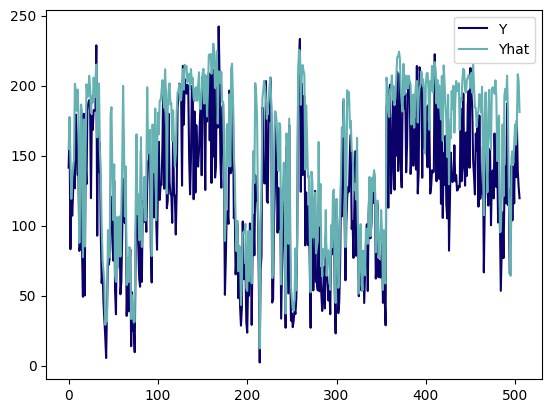

In [23]:
Yhat = A@beta_cr.reshape(-1,1)
plt.plot(Y, label = "Y")
plt.plot(Yhat, label = "Yhat")
plt.legend()